# Ensemble Model for Fake News Detection

This notebook implements an ensemble model combining various machine learning algorithms to classify news articles as real or fake. The implementation includes feature selection, model training, and evaluation metrics.

## Setup and Data Preparation
The following cell imports necessary libraries and sets up data processing tools. We'll use sklearn for machine learning tasks and suppress warnings for cleaner output.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

## Data Loading and Feature Selection
We load the preprocessed data from a CSV file and select relevant features for our model. The selected features include:
- Temporal features (year, month, day)
- Text-based probabilities
- Image predictions
- Engagement metrics (upvote ratio, number of comments, score)

In [2]:
# read the csv file

data = pd.read_csv('final_multimodal_train_with_probabilities_3k.csv')
X = data[['year','month','day','tfidf_probability','imgPredictions', 'upvote_ratio', 'num_comments', 'score']]
y = data['2_way_label']

## Feature Importance Analysis
We analyze feature importance using two methods:
1. Mutual Information Classification
2. Random Forest Feature Importance

This helps us understand which features contribute most to the classification task.

In [3]:
# Mutual Information
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns)

# Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
rf_importance = pd.Series(rf.feature_importances_, index=X.columns)

# Combine scores
feature_importance = pd.DataFrame({
    'Mutual_Information': mi_scores,
    'RF_Importance': rf_importance
})
feature_importance['Average_Importance'] = feature_importance.mean(axis=1)

## Feature Importance Visualization
Create a bar plot to visualize the relative importance of each feature in our classification task. This helps identify which features are most discriminative for detecting fake news.

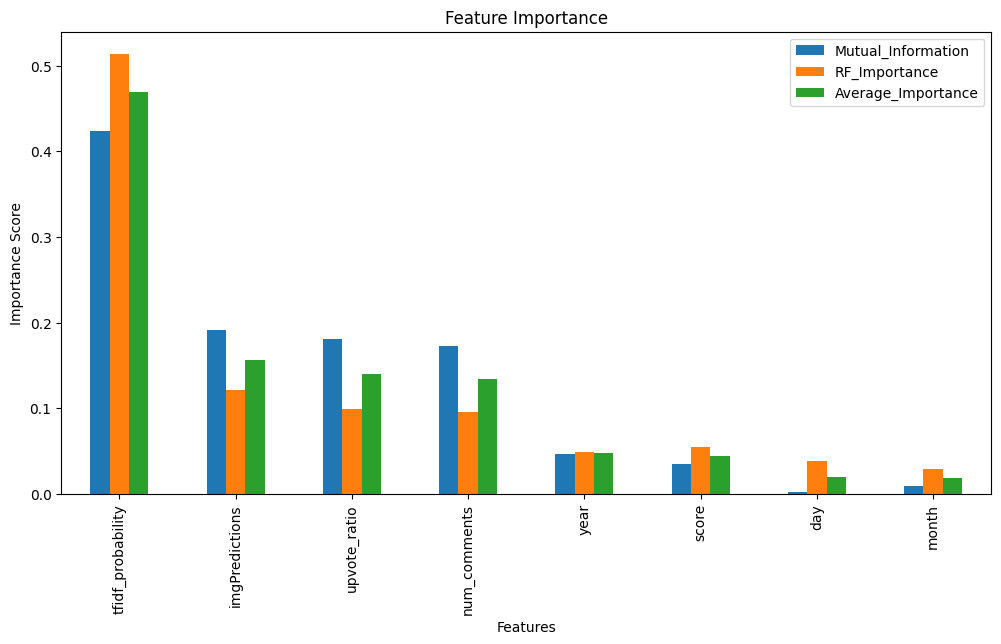

In [4]:
import matplotlib.pyplot as plt

# Plot feature importance
feature_importance.sort_values(by='Average_Importance', ascending=False, inplace=True)
feature_importance[['Mutual_Information', 'RF_Importance', 'Average_Importance']].plot(kind='bar', figsize=(12, 6))
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()

## Feature Selection Based on Importance
Select the top performing features based on the importance analysis to create our final feature set for modeling.

In [5]:
# Select top four features based on Average_Importance
top_features = feature_importance.sort_values(by='Average_Importance', ascending=False).head(4).index
X = X[top_features]
print(X.head())

   tfidf_probability  imgPredictions  upvote_ratio  num_comments
0           0.067640             0.0          0.88           0.0
1           0.000074             0.0          0.88           0.0
2           0.330587             0.0          0.86           3.0
3           0.034882             1.0          0.91           0.0
4           0.029600             0.0          0.88           0.0


## Train-Test Split
Split the data into training and test sets for model evaluation. We use:
- 80% of data for training
- 20% of data for testing
- A random subset of training data for initial model selection

In [6]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create smaller sample for initial model selection
sample_size = 0.3
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=sample_size, random_state=42)

## Model Selection and Evaluation
Test multiple classification models:
- Logistic Regression
- Random Forest
- XGBoost
- SVM
- Extra Trees
- Naive Bayes

Using cross-validation to evaluate performance and select the best performing models.

In [7]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier(),
    'SVM': SVC(probability=True),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100),
    'Naive Bayes': GaussianNB()
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_sample, y_sample, cv=cv, scoring='accuracy')
    results[name] = {
        'mean_score': scores.mean(),
        'std_score': scores.std()
    }

print("\nModel Evaluation Results:\n", results)


Model Evaluation Results:
 {'Logistic Regression': {'mean_score': 0.9186881748636415, 'std_score': 0.003489034909335542}, 'Random Forest': {'mean_score': 0.9111820933463092, 'std_score': 0.0038114605947835614}, 'XGBoost': {'mean_score': 0.9140314874167966, 'std_score': 0.003609802803391009}, 'SVM': {'mean_score': 0.6871924005852168, 'std_score': 0.007936880018483899}, 'Extra Trees': {'mean_score': 0.9083328925123968, 'std_score': 0.0039180765799687566}, 'Naive Bayes': {'mean_score': 0.9031206016034288, 'std_score': 0.0031827406483122644}}


## Model Performance Analysis
Analyze and display the performance of the top models based on cross-validation scores.

In [8]:
# Sort models by mean score and select top 2
top_models = dict(sorted(results.items(),
                         key=lambda x: x[1]['mean_score'],
                         reverse=True)[:3])

print("\nTop 3 Models:")
for name, scores in top_models.items():
    print(f"{name}: Mean Score = {scores['mean_score']:.4f} (±{scores['std_score']:.4f})")



Top 3 Models:
Logistic Regression: Mean Score = 0.9187 (±0.0035)
XGBoost: Mean Score = 0.9140 (±0.0036)
Random Forest: Mean Score = 0.9112 (±0.0038)


## Hyperparameter Configuration
Define hyperparameter search spaces for the top performing models to optimize their performance.

In [9]:
param_grids = {
    'Logistic Regression': {
    'penalty': ['l1', 'l2', 'elasticnet', None],   # Regularization type
    'C': [0.01, 0.1, 1, 10, 100],                 # Inverse regularization strength
    'solver': ['liblinear', 'saga', 'lbfgs'],     # Solvers that support different penalties
    'max_iter': [100, 200, 500]                   # Maximum number of iterations
    },

    'Random Forest': {
    'n_estimators': [50, 100, 200],               # Number of trees
    'max_depth': [None, 10, 20, 30],              # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],              # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],                # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None],       # Number of features considered for splits
    'bootstrap': [True, False]                    # Whether bootstrap sampling is used
    },

    'XGBoost': {
    'n_estimators': [50, 100, 200],                # Number of boosting rounds
    'max_depth': [3, 6, 10],                       # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.3],             # Step size shrinkage
    'subsample': [0.5, 0.8, 1.0],                  # Fraction of samples for each tree
    'colsample_bytree': [0.5, 0.8, 1.0],           # Fraction of features for each tree
    'gamma': [0, 0.1, 0.2],                        # Minimum loss reduction to make a split
    'reg_alpha': [0, 0.01, 0.1],                   # L1 regularization term
    'reg_lambda': [1, 1.5, 2]                      # L2 regularization term
    }
}

## Model Tuning
Perform randomized search cross-validation to find the best hyperparameters for each model.

In [10]:
from sklearn.model_selection import RandomizedSearchCV

for name in top_models.keys():
    if name in param_grids:
        print(f"\nTuning {name} with RandomizedSearchCV...")
        random_search = RandomizedSearchCV(models[name], param_distributions=param_grids[name],
                                           n_iter=50,  # Number of random samples
                                           cv=5, n_jobs=-1, random_state=42)
        random_search.fit(X_train, y_train)
        top_models[name] = random_search.best_estimator_
        print(f"Best parameters: {random_search.best_params_}")
        print(f"Best cross-validation score: {random_search.best_score_:.4f}")



Tuning Logistic Regression with RandomizedSearchCV...
Best parameters: {'solver': 'lbfgs', 'penalty': None, 'max_iter': 500, 'C': 10}
Best cross-validation score: 0.9185

Tuning XGBoost with RandomizedSearchCV...
Best parameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
Best cross-validation score: 0.9224

Tuning Random Forest with RandomizedSearchCV...
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
Best cross-validation score: 0.9209


## Final Model Evaluation
Evaluate the tuned models on the test set using multiple metrics:
- Accuracy
- Precision
- Recall
- F1-score

In [11]:
# Final evaluation on test set
print("\nFinal Test Set Evaluation:")
for name, model in top_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


Final Test Set Evaluation:

Logistic Regression:
Accuracy: 0.9153

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7293
           1       0.90      0.89      0.89      4698

    accuracy                           0.92     11991
   macro avg       0.91      0.91      0.91     11991
weighted avg       0.92      0.92      0.92     11991


XGBoost:
Accuracy: 0.9199

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      7293
           1       0.91      0.88      0.90      4698

    accuracy                           0.92     11991
   macro avg       0.92      0.91      0.92     11991
weighted avg       0.92      0.92      0.92     11991


Random Forest:
Accuracy: 0.9184

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      7293
           1       0.91      0.88     

In [13]:
# Save best model
import joblib
best_model_name = max(top_models.items(), key=lambda x: accuracy_score(y_test, x[1].predict(X_test)))[0]
joblib.dump(top_models[best_model_name], 'ensembleModel.joblib')
print(f"\nBest model ({best_model_name}) saved as 'ensembleModel.joblib'")


Best model (XGBoost) saved as 'ensembleModel.joblib'


## Model Performance Visualization
Create visualizations to evaluate model performance:
1. Confusion Matrix
2. ROC Curve
3. Precision-Recall Curve

These visualizations help understand the model's strengths and weaknesses in different classification scenarios.

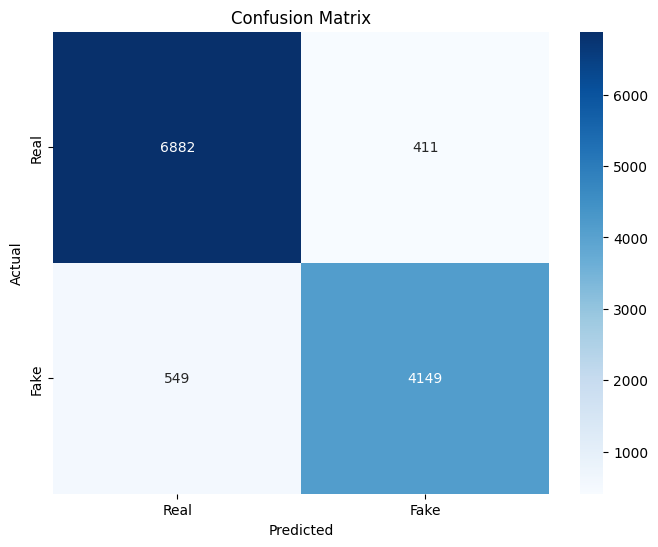

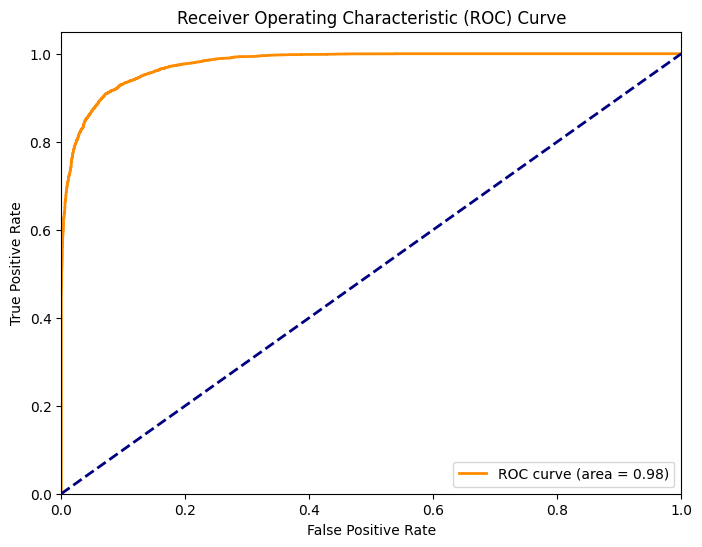

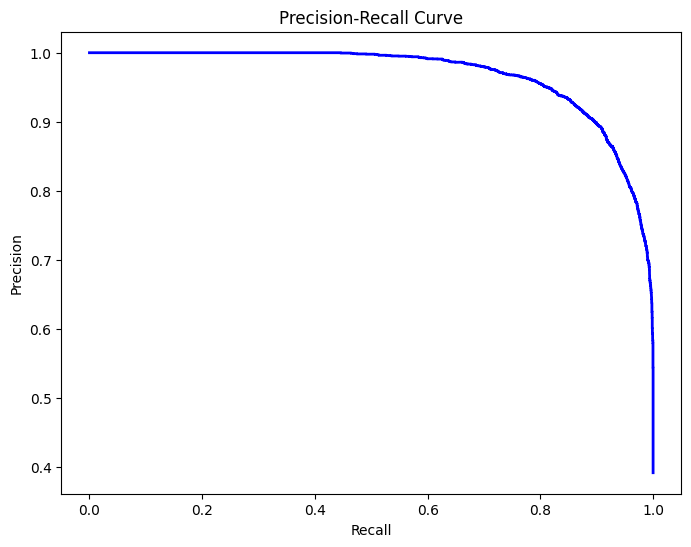

In [14]:
import joblib
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

import matplotlib.pyplot as plt

# Load the saved model
model = joblib.load('ensembleModel.joblib')

# Predict on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()